In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

from glob import glob
from os.path import join
from scipy import interpolate

import itertools
import datetime
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2
ALTITUDE = 3

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
#     tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Fri Sep  4 15:18:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   29C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def plot_altitude_rmse(nnet, X, T, NWP_Temp, file_name=None):
    """
    Plot the RMSE over different altitudes for some NeuralNetwork architecture.

    :params
    ---
    nnet : class
        Trained Neural Network class that will be used for evaluation
    X : np.array
        Input to the trained nnet
    T : np.array
        Targets to compare to for the nnet. Will often be the temperature profile from the RAOB.
    NWP_Temp : np.array
        Temperature profile from the NWP mode. Should have the same shape T.
    """
    default_font = 12
    figure_width = 12
    figure_height = 4
    line_width = 2
    
    if file_name:
        default_font = 14
        figure_width = 12
        figure_height = 4
        line_width = 2.5
        
    def plot_rmse(rmse, mean_rmse, color, label):
            axs[0].plot(alt, rmse, color=color, linewidth=line_width)
            axs[0].hlines(mean_rmse, alt[0], alt[-1], label=f'{label} {mean_rmse:.3f}',
                          color=color, linestyle='--', linewidth=line_width)

            axs[1].plot(alt[:surface_error], rmse[:surface_error], color=color, linewidth=line_width)
            axs[1].hlines(mean_rmse, alt[:surface_error][0], alt[:surface_error][-1],
                          color=color, linestyle='--', linewidth=line_width)
            
    alt = raob[0, :, ALTITUDE]
    surface_error = 100
    
    fig, axs = plt.subplots(1, 2, figsize=(figure_width, figure_height))
    axs = axs.ravel()
    
    rap_rmse = np.sqrt((np.mean((NWP_Temp - T)**2, axis=0)))
    rap_mean_rmse = ml.rmse(NWP_Temp, T)
    plot_rmse(rap_rmse, rap_mean_rmse, 
              radiosonde_plotting.colour_from_numpy_to_tuple(
                  radiosonde_plotting.DEFAULT_OPTION_DICT[radiosonde_plotting.NWP_LINE_COLOUR_KEY]), 
              'NWP')
    
    Y = nnet.use(X)
    ml_rmse = np.sqrt((np.mean((Y - T)**2, axis=0)))
    ml_mean_rmse = ml.rmse(Y, T)
    plot_rmse(ml_rmse, ml_mean_rmse,
              radiosonde_plotting.colour_from_numpy_to_tuple(
                  radiosonde_plotting.DEFAULT_OPTION_DICT[radiosonde_plotting.PREDICTED_LINE_COLOUR_KEY]),
              'ML')

    axs[0].set_xlabel('Altitude (m)', fontsize=default_font)
    axs[1].set_xlabel('Altitude (m)', fontsize=default_font)
    axs[0].set_ylabel('RMSE (C)', fontsize=default_font)
    axs[0].legend(fontsize=default_font);
    
    for ax in axs:
        ax.tick_params(axis='x', labelsize=default_font)
        ax.tick_params(axis='y', labelsize=default_font)
        ax.grid(True)
    
    if file_name:
        plt.savefig(file_name, dpi=300)
        plt.show()
        plt.close()
    
    
def plot_loss(nnet):
    fig, ax = plt.subplots(1, figsize=(8, 4))

    ax.plot(nnet.history['loss'], label='train')
    ax.plot(nnet.history['val_loss'], label='val')
    ax.legend();

# Data Loader

In [5]:
# TODO: Should this be done in preprocessing?

def interpolate_to_height_intervals(alt, y, altitude_intervals):
    f = interpolate.interp1d(alt, y)
    return f(altitude_intervals)


def load_samples():
    files = sorted(glob(join(processed_vol, '*')))
    print(f'total of {len(files)} samples!')
    
    fp = FloatProgress(min=0, max=(len(files)))
    display(fp)
    
    sonde_files = []
    raob = []
    rap = []
    goes = []
    rtma = []
    
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        raob_profile = np.concatenate((xar.sonde_pres.values.reshape(-1,1),
                                       xar.sonde_tdry.values.reshape(-1,1),
                                       xar.sonde_dp.values.reshape(-1,1),
                                       xar.sonde_alt.values.reshape(-1,1)), axis=1)
        raob.append(raob_profile)
        
        alt = xar.nwp_alt.values
        altitude_intervals = np.linspace(alt[0], 18_000, 256)
        
        p = xar.nwp_pres.values
        t = xar.nwp_tdry.values-272.15 # convert to deg C
        q = xar.nwp_spfm.values
        
        pres = interpolate_to_height_intervals(alt, p/100., altitude_intervals)  # convert Pa to hPa
        tdry = interpolate_to_height_intervals(alt, t, altitude_intervals)
        
        epsilon = 0.622
        A = 17.625
        B = 243.04 # deg C
        C = 610.94 # Pa
        
        # vapor pressure
        e = p*q / (epsilon + (1 - epsilon)*q)
        
        if e[0] == 0: # replace first value with eps if zero
            e[0] = np.finfo(float).eps
        if e.all() == 0: # forward fill values where zero exist
            prev = np.arange(len(e))
            prev[e == 0] = 0
            prev = np.maximum.accumulate(prev)
            e = e[prev]
        # dewpoint temperature 
        td = B * np.log(e/C) / (A - np.log(e/C))

        td = interpolate_to_height_intervals(alt, td, altitude_intervals)
        
        rap_profile = np.concatenate((pres.reshape(-1,1),
                                      tdry.reshape(-1,1),
                                      td.reshape(-1,1),
                                      altitude_intervals.reshape(-1,1)), axis=1)
        rap.append(rap_profile)
        goes.append(xar.goes_abi.values)
        rtma.append(xar.rtma_values.values)
        sonde_files.append(str(xar.sonde_file.values))
        xar.close()
        fp.value += 1

    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/len(files):.3f} seconds')
    
    return (np.array(raob), np.array(rap), np.array(goes).transpose(0, 2, 3, 1),
            np.array(rtma).transpose(0, 2, 3, 1), sonde_files)

raob, rap, goes, rtma, sonde_files = load_samples()

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 431 samples!


FloatProgress(value=0.0, max=431.0)

time: 11.377, avg: 0.026 seconds
(431, 256, 4) (431, 256, 4) (431, 3, 3, 8) (431, 3, 3, 3)


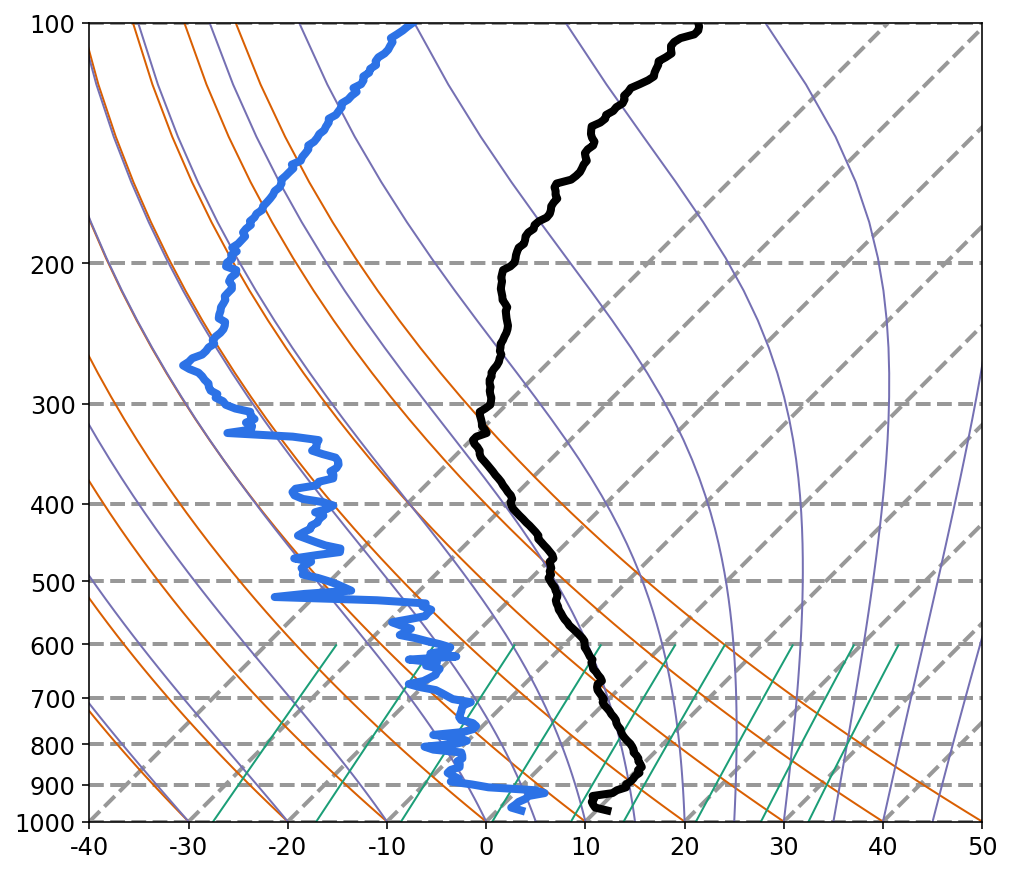

In [78]:
index = 2

sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = raob[index,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,TEMPERATURE]
sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,DEWPOINT]

radiosonde_plotting.plot_sounding(sounding);

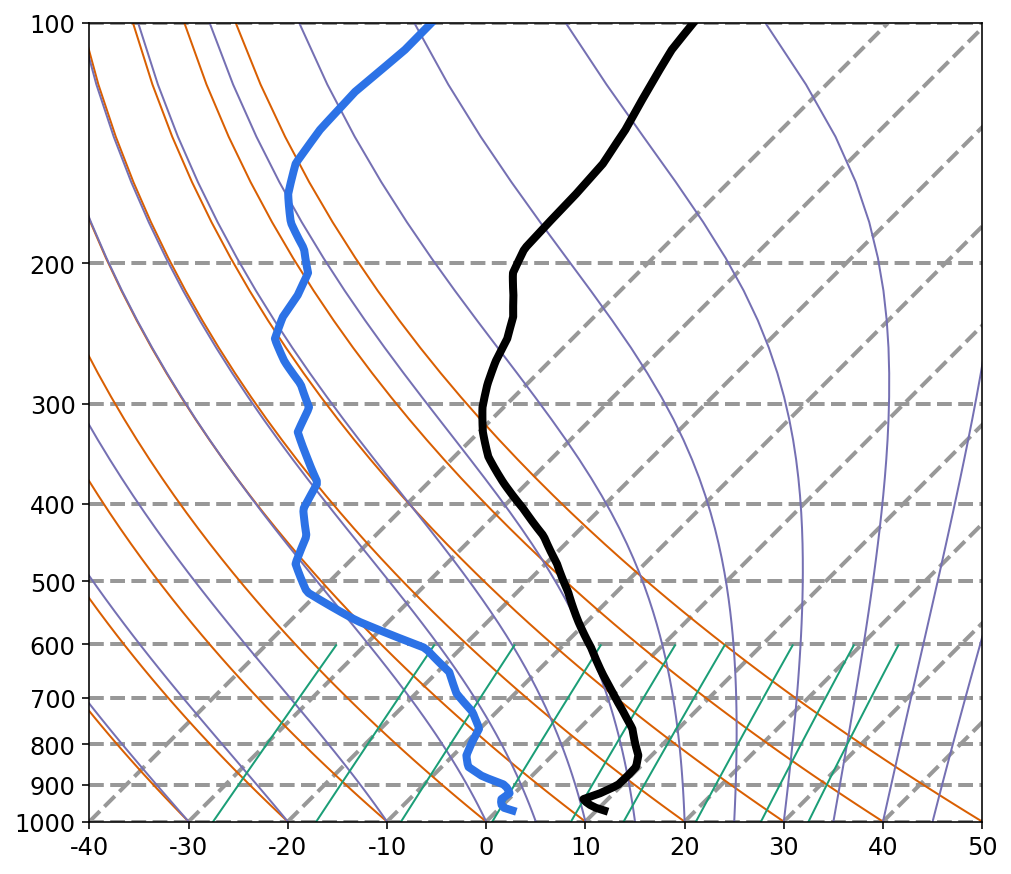

In [79]:
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = rap[index,:,TEMPERATURE]
sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = rap[index,:,DEWPOINT]

radiosonde_plotting.plot_sounding(sounding);

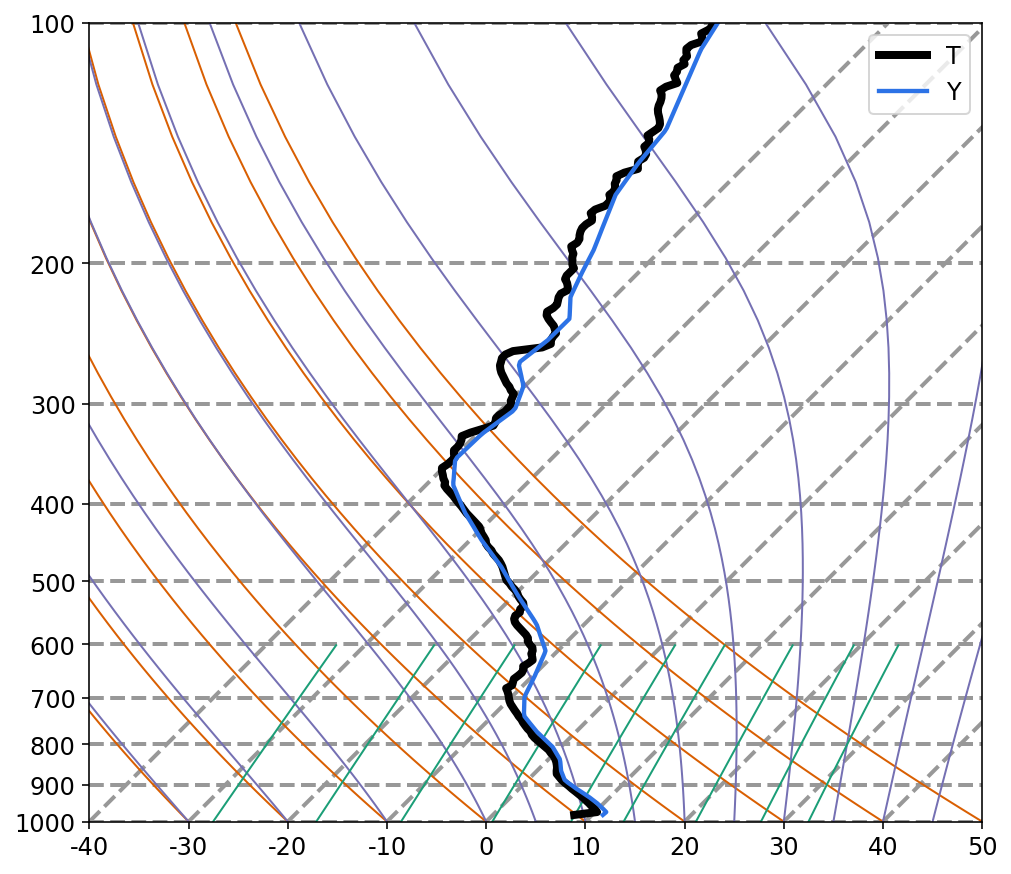

In [80]:
index = 11
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = raob[index,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = rap[index,:,TEMPERATURE]

radiosonde_plotting.plot_predicted_sounding(sounding);

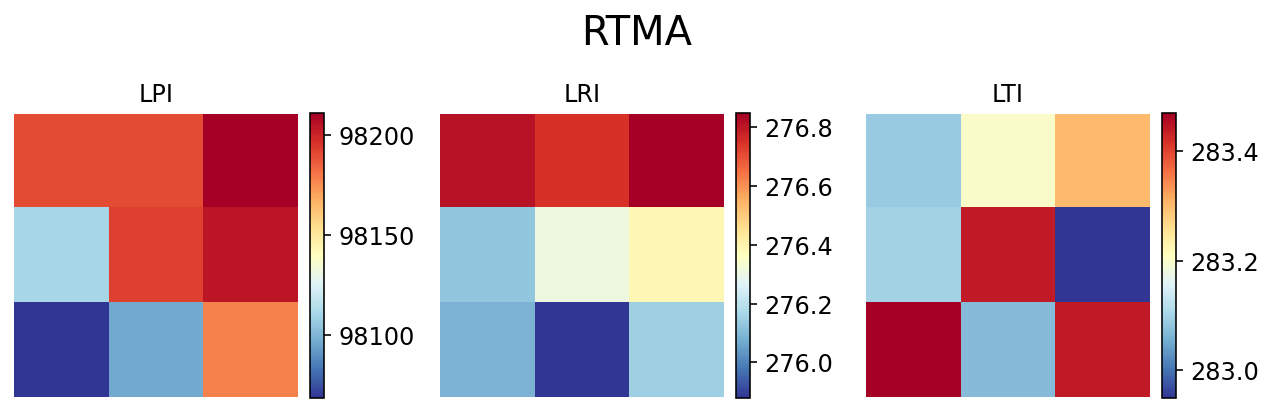

In [154]:
rtma_type = np.array(['LPI', 'LRI', 'LTI'])

fig, axs = plt.subplots(1, 3, figsize=(9,3))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    c = axs[i].imshow(rtma[index,:,:,i], cmap=PLOT_CMAP)
    fig.colorbar(c, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_title(f'{str(rtma_type[i])}')
fig.suptitle('RTMA', fontsize=20)
fig.tight_layout()

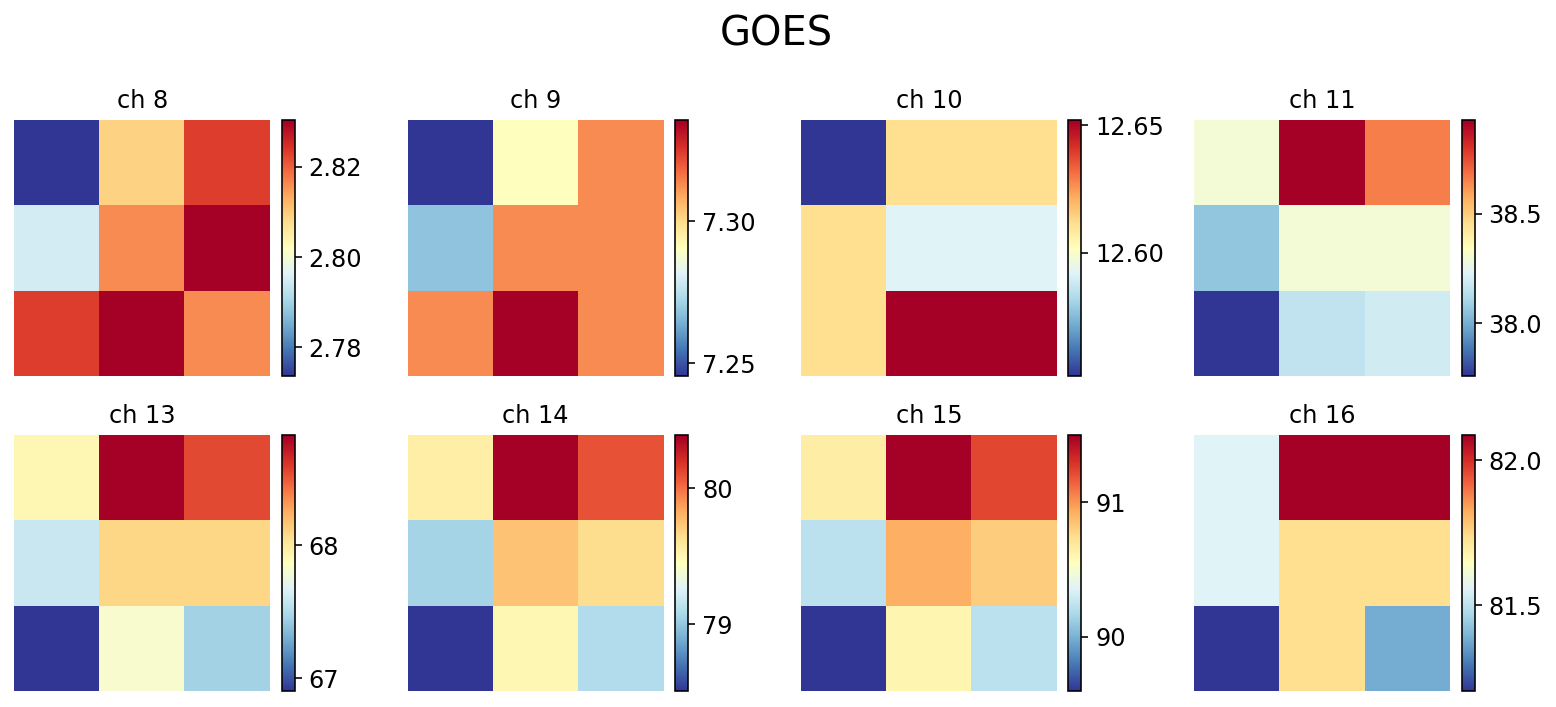

In [155]:
bands = np.array([8, 9, 10, 11, 13, 14, 15, 16])

# vmin = goes[index,:,:,:].min()
# vmax = goes[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(11,5))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    c = axs[r, i % 4].imshow(goes[index,:,:,i], cmap=PLOT_CMAP) # vmin=vmin, vmax=vmax,
    cbar = fig.colorbar(c, ax=axs[r, i % 4], fraction=0.046, pad=0.04)
    cbar.ax.locator_params(nbins=3)
    axs[r, i % 4].set_title(f'ch {str(bands[i])}')
plt.suptitle('GOES', fontsize=20)
fig.tight_layout()

# RAP

## Linear NN

In [6]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((345, 512), (345, 256), (86, 512), (86, 256))

In [7]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

nnet.model.summary()

nnet.train(Xt, Tt, 50, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________
epoch: 0, loss: 0.93308
epoch: 5, loss: 0.09962
epoch: 10, loss: 0.07356
epoch: 15, loss: 0.06412
epoch: 20, loss: 0.05994
epoch: 25, loss: 0.05796
epoch: 30, loss: 0.05698
epoch: 35, loss: 0.05596
epoch: 40, loss: 0.05446
epoch: 45, loss: 0.05488
epoch: 49, loss: 0.05547
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.05547 in 2.3494 seconds.

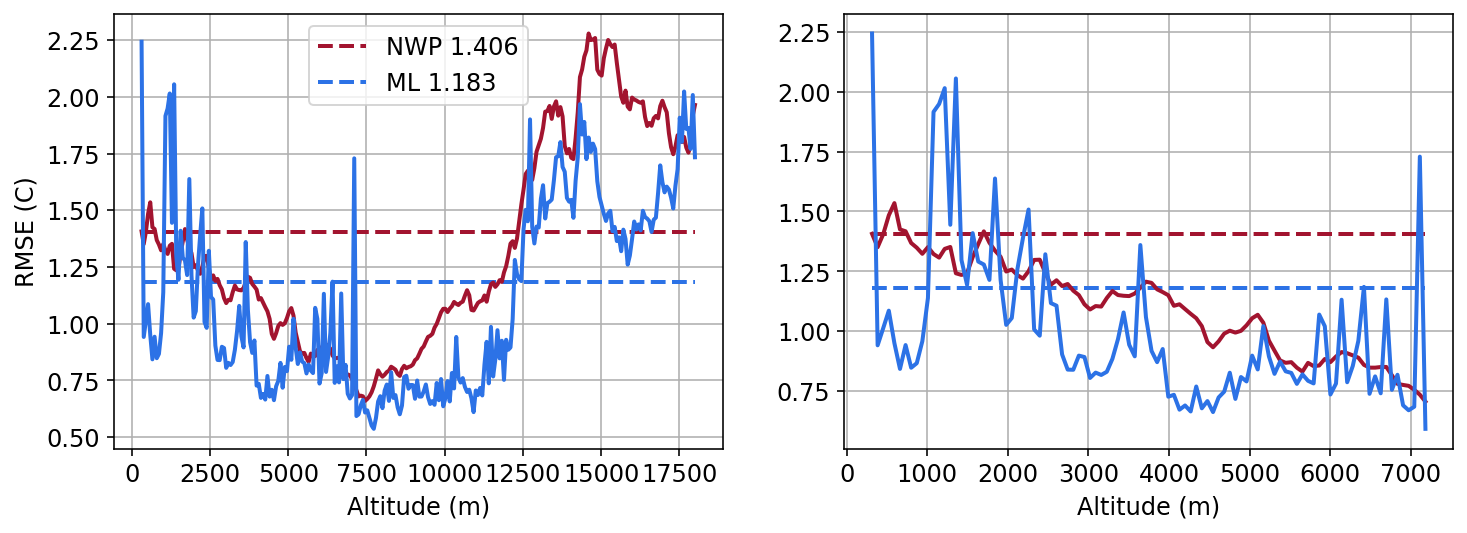

In [8]:
plot_altitude_rmse(nnet, Xe, Te, Xtest[:,:,TEMPERATURE])

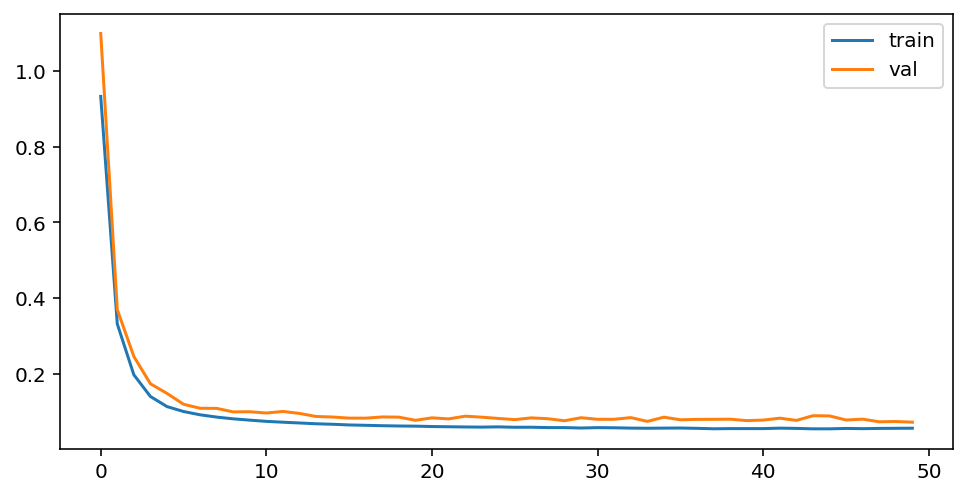

In [9]:
plot_loss(nnet)

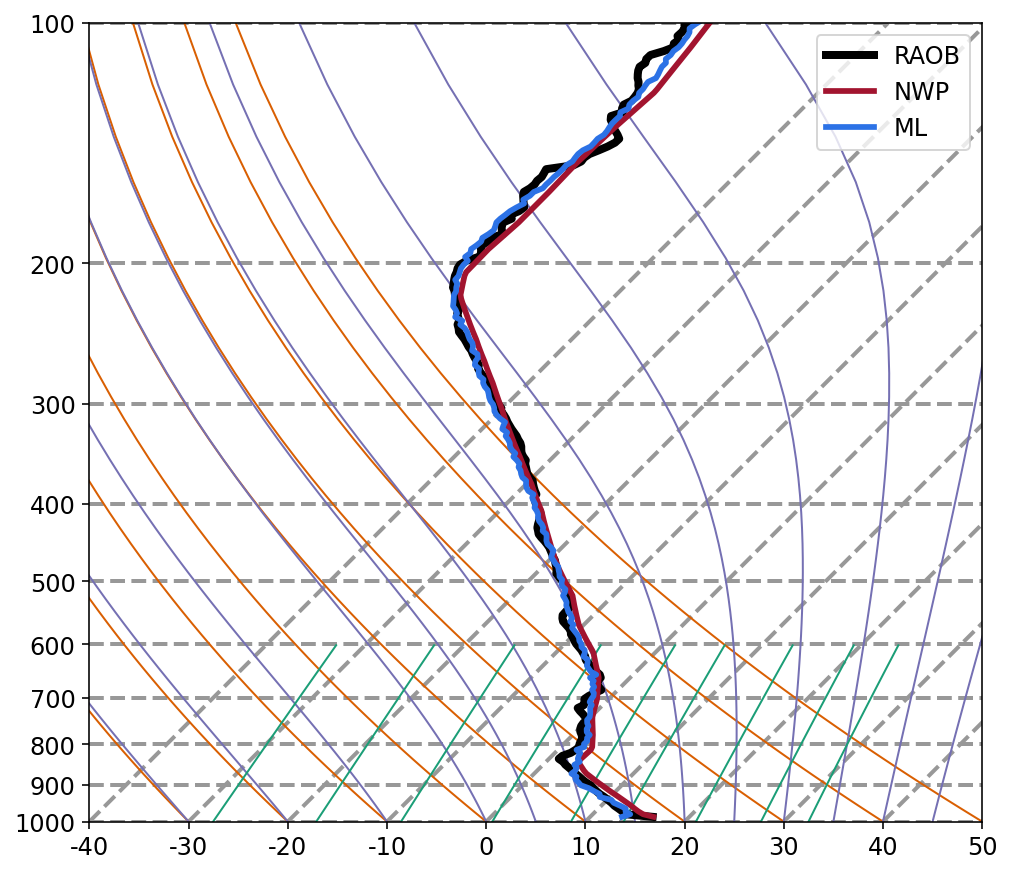

In [10]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Fully Connected NN

In [11]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((345, 512), (345, 256), (86, 512), (86, 256))

In [12]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[nu] * nl for nu in [4, 8, 16, 32, 64] for nl in range(1, 5)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.NeuralNetwork(Xt.shape[1], layer, Tt.shape[1], activation='tanh', seed=1234)

    nnet.train(Xt, Tt, 50, 16, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xt)
    train_percentage.append(ml.rmse(Tt, Y))

    Y = nnet.use(Xe)
    temp = ml.rmse(Te, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=20.0)

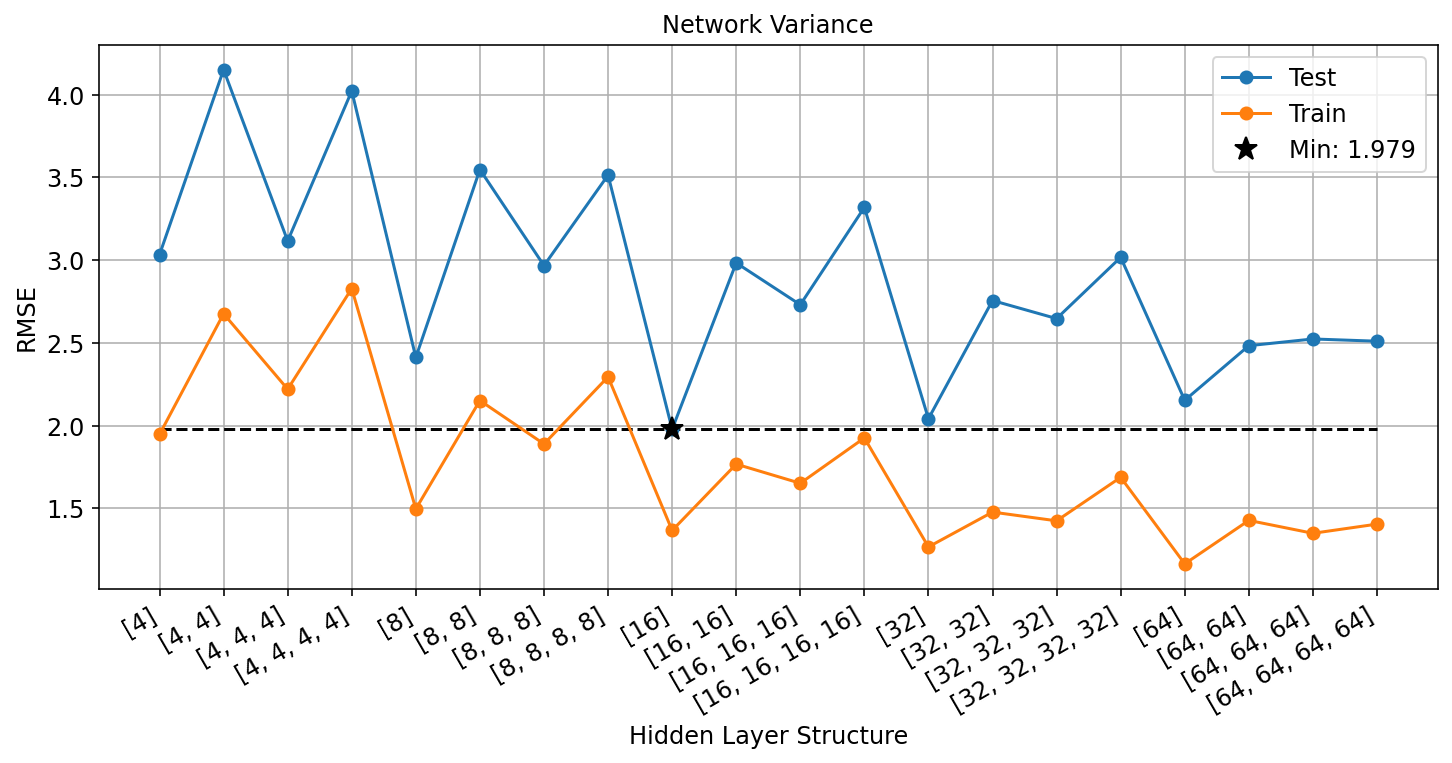

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

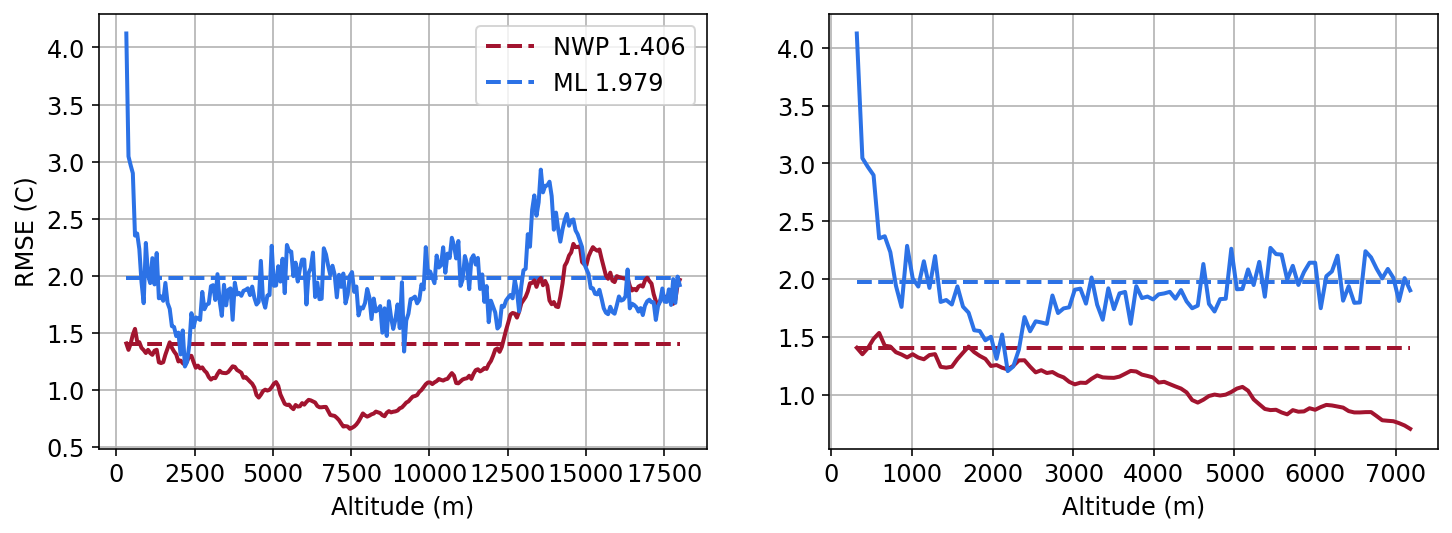

In [14]:
plot_altitude_rmse(best_nnet, Xe, Te, Xtest[:,:,TEMPERATURE])

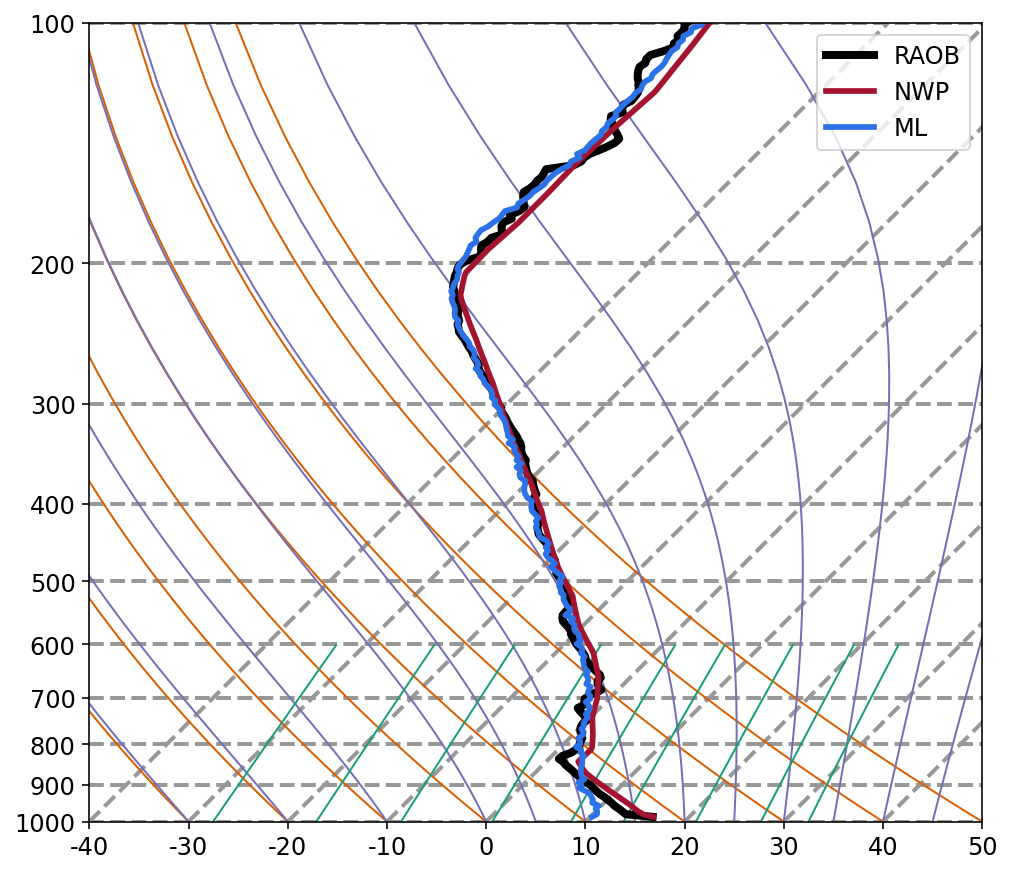

In [15]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Conv1D NN

In [16]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((345, 256, 2), (345, 256), (86, 256, 2), (86, 256))

In [17]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], layer, [(10, 1)]*len(layer),
                                         Ttrain.shape[1], activation='tanh', seed=1234)
    nnet.train(Xtrain, Ttrain, 25, 32, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(ml.rmse(Ttrain, Y))

    Y = nnet.use(Xtest)
    temp = ml.rmse(Ttest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=17.0)

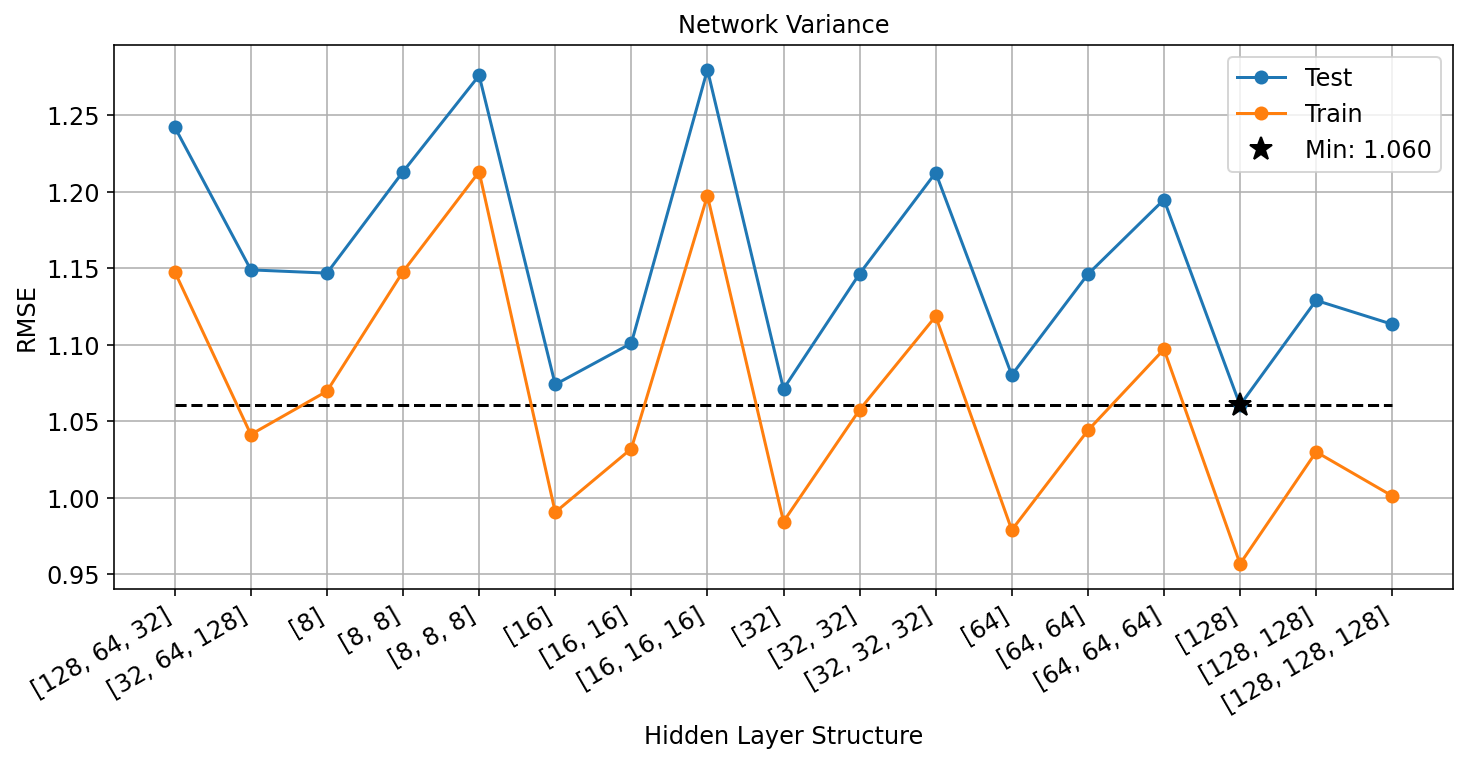

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

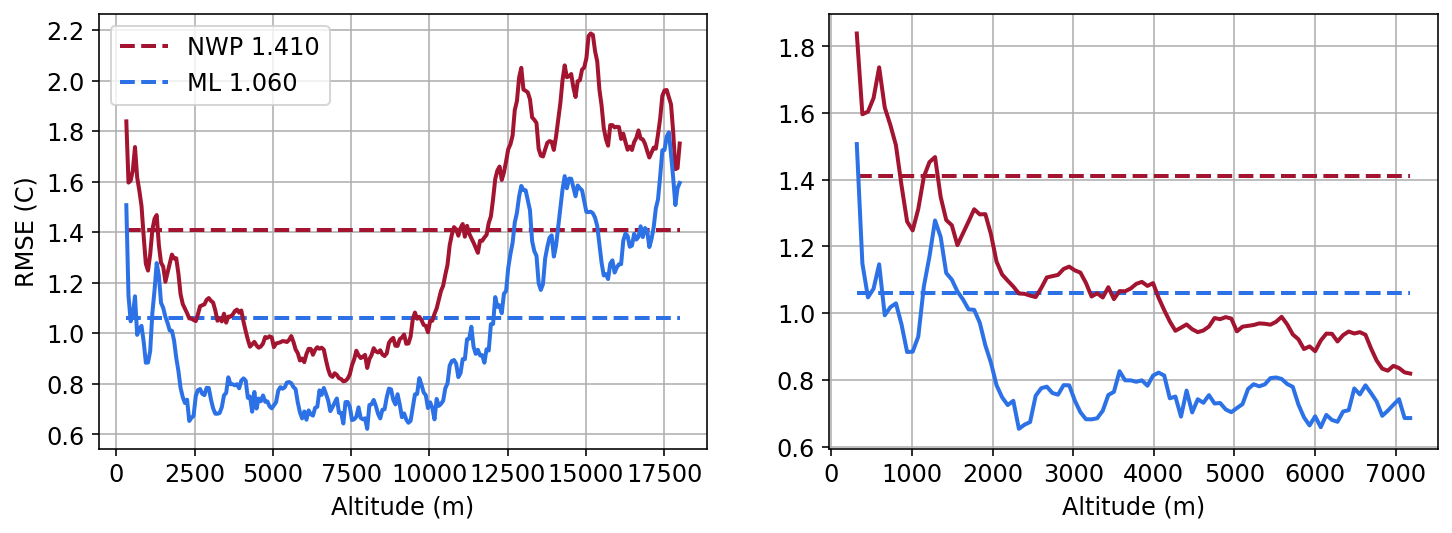

In [19]:
plot_altitude_rmse(best_nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE])

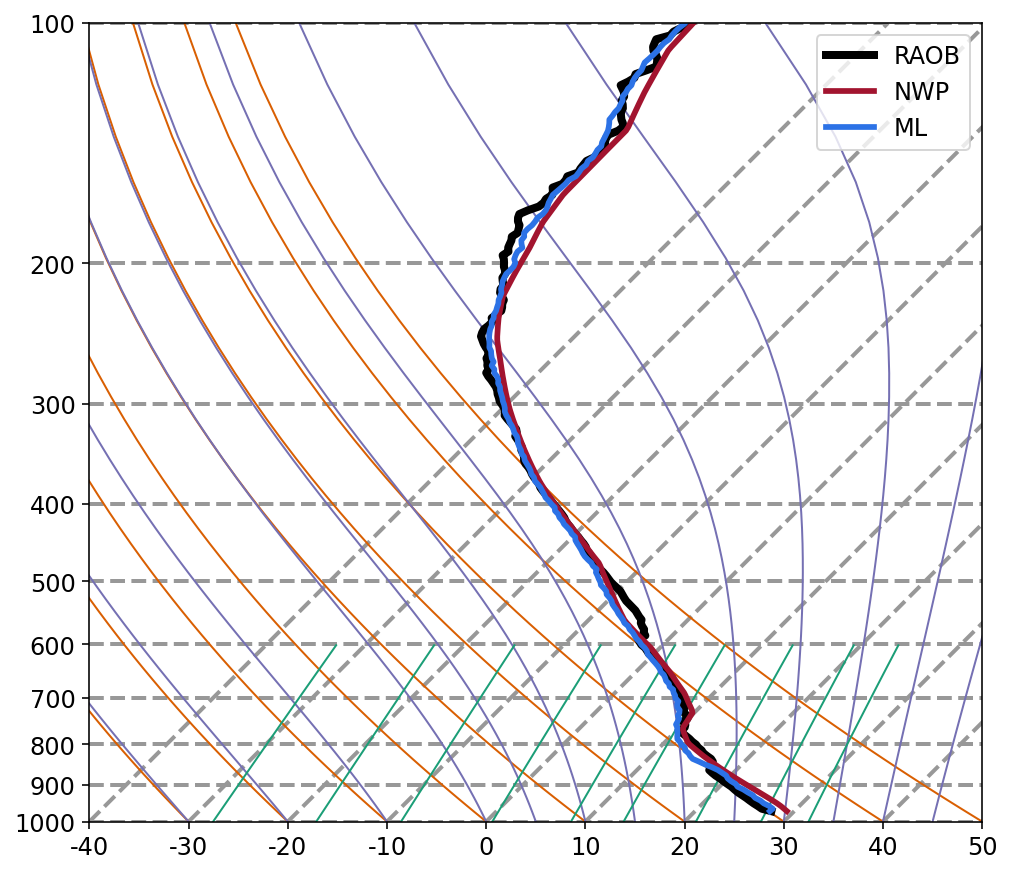

In [20]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

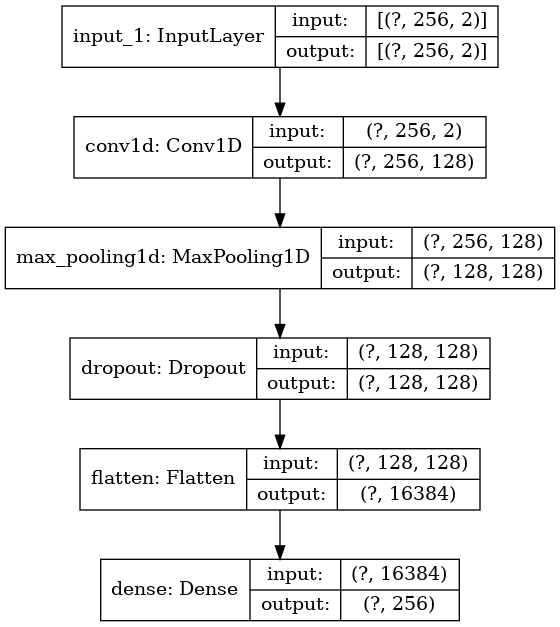

In [21]:
tf.keras.utils.plot_model(best_nnet.model, '/home/stock/research/media/rap_only_network.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

## RAP CAE

In [23]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((345, 256, 2), (345, 256), (86, 256, 2), (86, 256))

In [24]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
hidden_dims = [32, 64, 128]
train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(hidden_dims, layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for hidden_dims, layer in product:
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], layer, [(10, 1)]*len(layer),
                                       Ttrain.shape[1], activation='tanh',
                                       n_hidden_dims=hidden_dims, seed=1234)
    nnet.train(Xtrain, Ttrain, 25, 32, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(ml.rmse(Ttrain, Y))

    Y = nnet.use(Xtest)
    temp = ml.rmse(Ttest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=36.0)

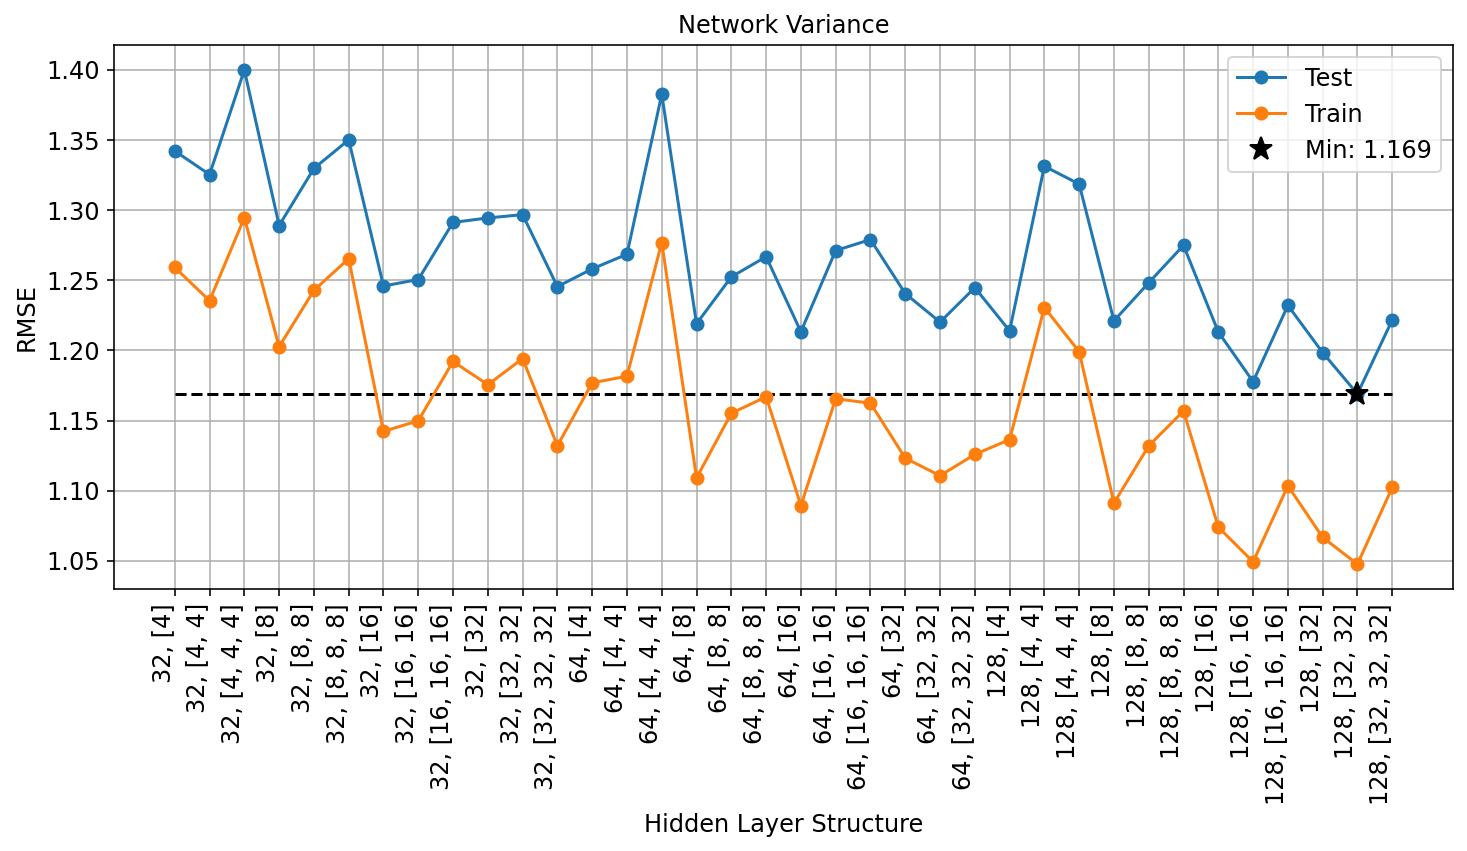

In [25]:
# 1.071 using tanh and PRESSURE, TEMPERATURE
plt.figure(figsize=(12, 5))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

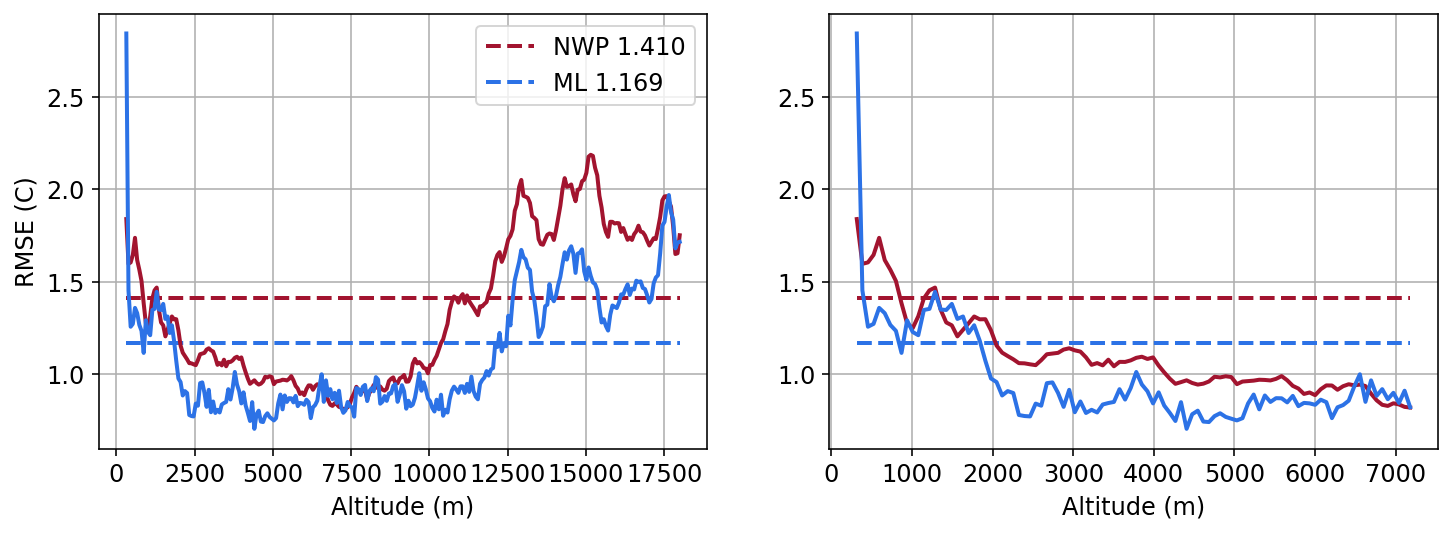

In [27]:
plot_altitude_rmse(best_nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

## Transfer Learning RAOB

Best performance is noticed when retraining over the entire model, or freezing the weights before the latent vector.

In [28]:
def insert_intermediate_layer(model, layer_regex, layer_factory):
    x = model.layers[0].output
    for layer in model.layers[1:]:
        x = layer(x)
        if re.match(layer_regex, layer.name):
            new_layer = layer_factory()
            new_layer._name = f'{layer.name}_{new_layer.name}'
            x = new_layer(x)
            print(f'Added {new_layer.name} after {layer.name}')
    return tf.keras.Model(model.layers[0].input, x)

In [29]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((345, 256, 2), (345, 256), (86, 256, 2), (86, 256))

In [30]:
## 0.970 with raob_cae freeze before `dense` with 20, 32, 0.0001 'adam'
nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_cae')

def dropout_layer_factory():
    return tf.keras.layers.Dropout(rate=0.1, name='dropout')
def batchnorm_layer_factory():
    return tf.keras.layers.BatchNormalization(name='batch_norm')

# (?<![\w\d])dense(?![\w\d])
# nnet.model = insert_intermediate_layer(nnet.model, '(?<![\w\d])conv1d(?![\w\d])', batchnorm_layer_factory)
# nnet.model = insert_intermediate_layer(nnet.model, 'up_sampling1d', dropout_layer_factory)

for layer in nnet.model.layers:
    ## Freeze all except for ...
    # if layer.name != 'dense':
    #     layer.trainable = False
    if layer == nnet.model.get_layer('dense'):
        break
    layer.trainable = False
    
nnet.train(Xtrain, Ttrain, 20, 32, validation=[Xtest, Ttest], method='adam',
           learning_rate=0.0001, verbose=False)

ConvolutionalAutoEncoder((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.04101 in 3.0953 seconds.

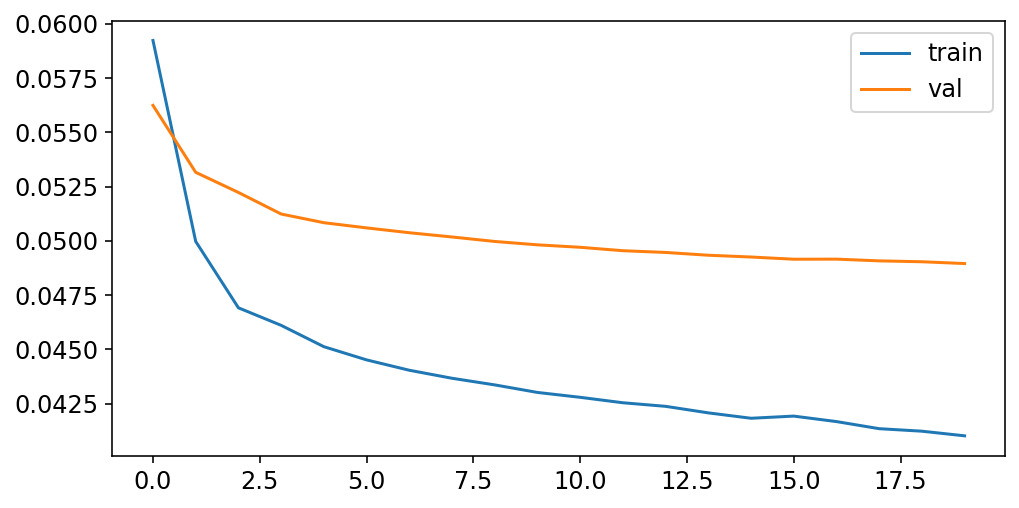

In [31]:
plot_loss(nnet)

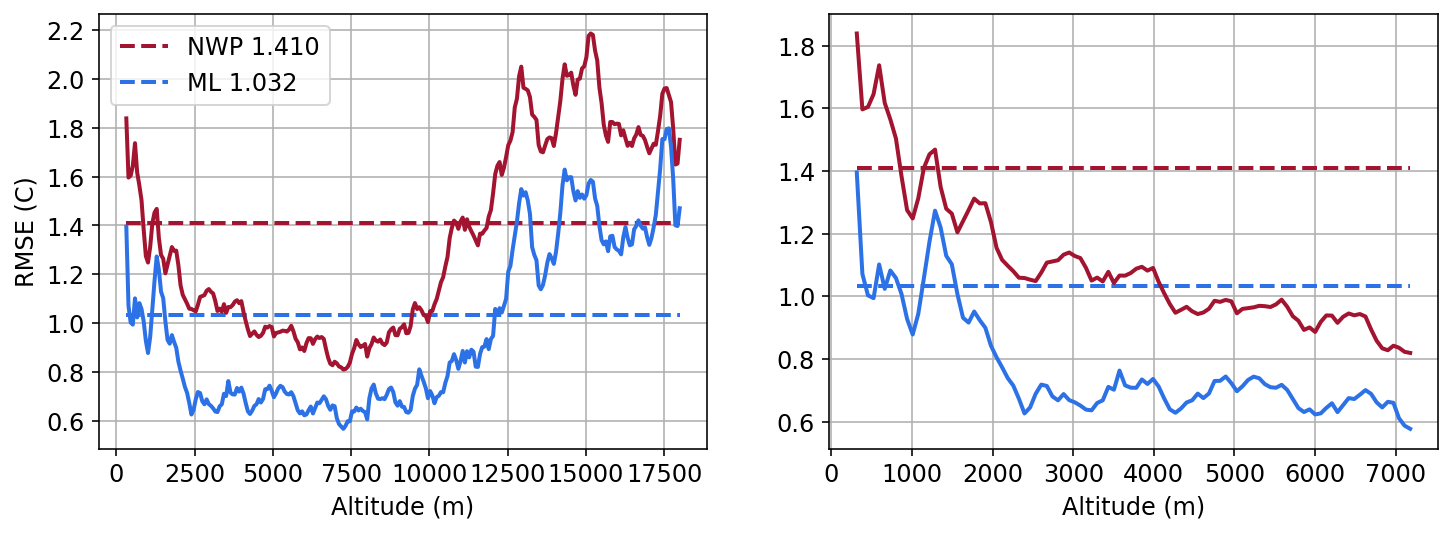

In [32]:
plot_altitude_rmse(nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE])
                   #file_name=f"/home/stock/research/media/transfer_learning_rmse.png")  

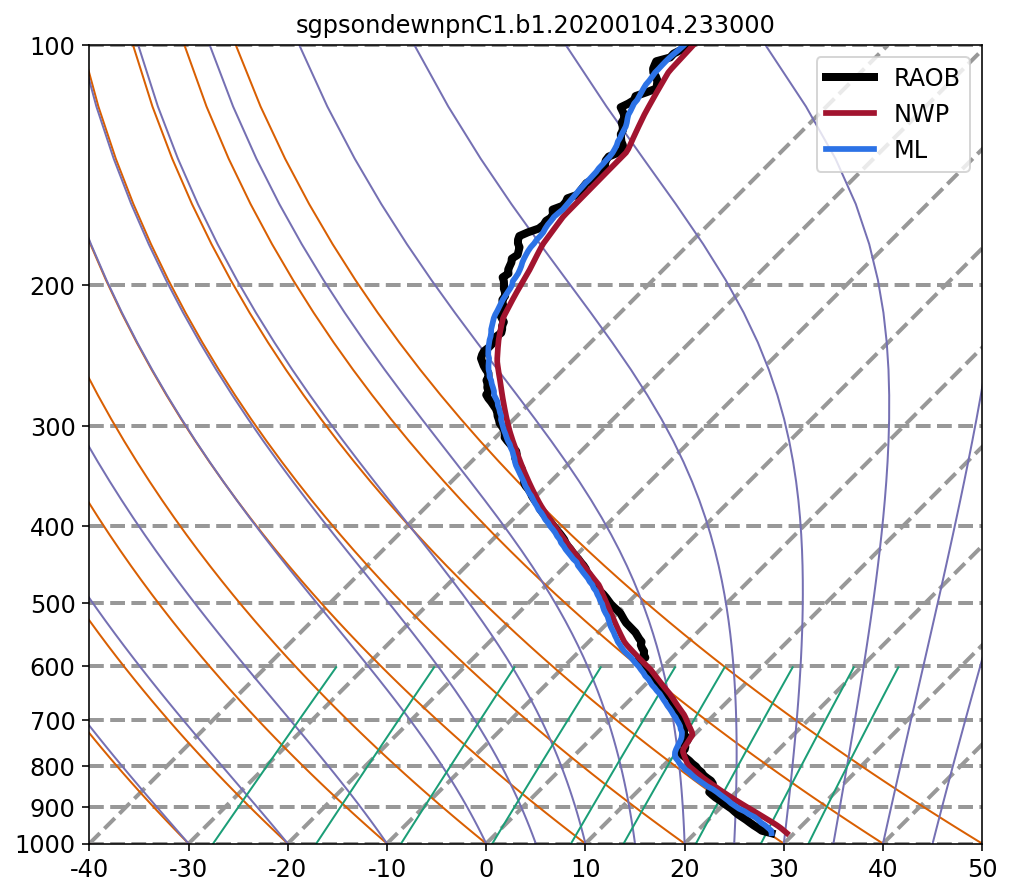

In [33]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

title = sonde_files[i].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         #file_name=f"/home/stock/research/media/{title}.png");

## Dewpoint from Specific Humidity

The RAP files use specific humidity as the moisture variable.  Here is the procedure to convert specific humidity to dewpoint temperature.  

The first step is to convert the specific humidity to vapor pressure:

$$e = \frac{pq}{\epsilon + (1-\epsilon)q}\;\;(1)$$  

Where $\epsilon = 0.622$ is the ratio of gas constants for dry air and water vapor, $e$ is the **water vapor pressure**, and $p$ is the **total pressure** (dry air plus water vapor), and $q$ is the **specific humidity**.  

There are many equations that relate the saturation vapor pressure ($e_s$) to temperature $T$.  One that is convenient for what we are doing is:

$$e_s = Ce^{\frac{AT}{B+T}}$$  

An analogous equation relates vapor pressure to dewpoint temperature:  

$$e = Ce^{\frac{AT_d}{B+T_d}}$$    

Alduchov and Eskridge (1996) suggest the following coefficients: $A=17.625$, $B=243.04$°C, and $C=610.94$ Pa.  

Solving for $T_d$ gives:  

$$T_d = \frac{Bln(\frac{e}{C})}{A-ln(\frac{e}{C})}\;\;(2)$$  

Note that $C$ has units of Pa, not the usual millibars (or hPa).  But the RAP pressure is given in units of Pa, and $q$ is unitless (kg/kg).  So you can plug those values right into (1) to get the vapor pressure, which will also be in Pa, then go to (2) to get the dewpoint temperature in °C.  

This formulation holds if the pressure in the RAP is the total pressure, not just the pressure of the dry air.

# RAP + GOES

In [34]:
def parition(rap=None, raob=None, goes=None, rtma=None, 
             percentages=(0.8,0.2), shuffle=True):
    
    trainFraction, testFraction = percentages
    n = raob.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    rowIndices = np.arange(n)
    if shuffle:
        np.random.shuffle(rowIndices)
        
    RAPtrain = rap[rowIndices[:nTrain], :] if rap is not None else None
    RAOBtrain = raob[rowIndices[:nTrain], :] if raob is not None else None
    GOEStrain = goes[rowIndices[:nTrain], :] if goes is not None else None
    RTMAtrain = rtma[rowIndices[:nTrain], :] if rtma is not None else None
    
    RAPtest = rap[rowIndices[nTrain:nTrain+nTest], :] if rap is not None else None
    RAOBtest = raob[rowIndices[nTrain:nTrain+nTest], :] if raob is not None else None
    GOEStest = goes[rowIndices[nTrain:nTrain+nTest], :] if goes is not None else None
    RTMAtest = rtma[rowIndices[nTrain:nTrain+nTest], :] if rtma is not None else None
    
    return (RAPtrain, RAOBtrain, GOEStrain, RTMAtrain,
            RAPtest, RAOBtest, GOEStest, RTMAtest)

In [35]:
RAPtrain, RAOBtrain, GOEStrain, _, RAPtest, RAOBtest, GOEStest, _ = parition(rap=rap, raob=raob, goes=goes)

input_dims = [PRESSURE, TEMPERATURE]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, TEMPERATURE]

# GOEStrain = GOEStrain[:, :, :, 0:1]
# GOEStest = GOEStest[:, :, :, 0:1]

RAPtrain.shape, RAOBtrain.shape, GOEStrain.shape, RAPtest.shape, RAOBtest.shape, GOEStest.shape

((345, 256, 2),
 (345, 256),
 (345, 3, 3, 8),
 (86, 256, 2),
 (86, 256),
 (86, 3, 3, 8))

In [36]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [4, 8, 16] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(GOEStrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], goes_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(GOEStrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': GOEStrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': GOEStest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

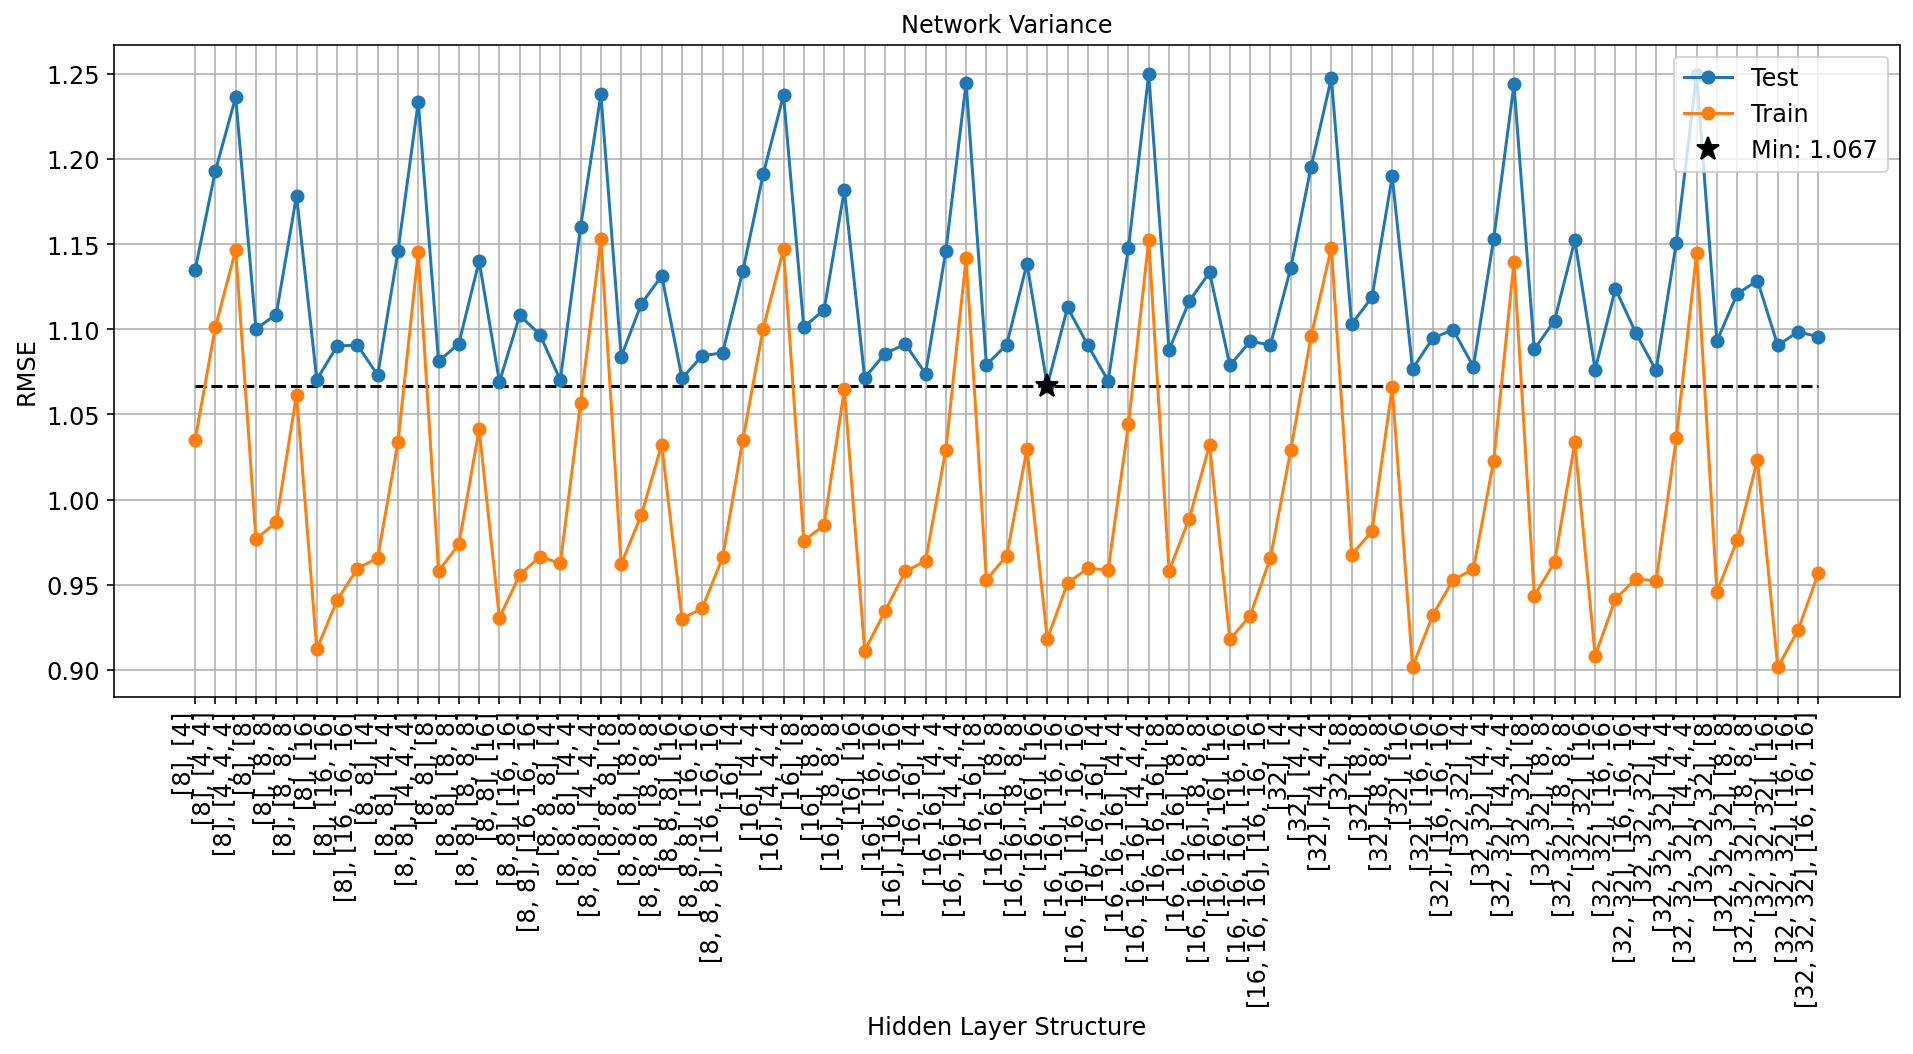

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

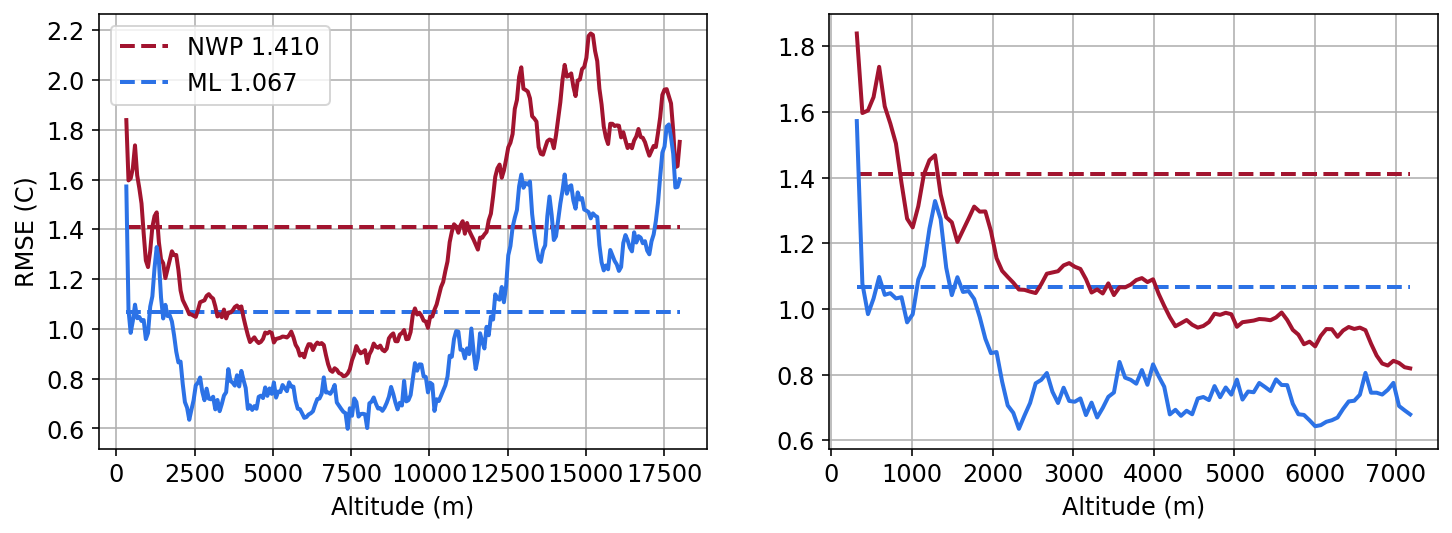

In [38]:
plot_altitude_rmse(best_nnet, {'im': GOEStest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,TEMPERATURE])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

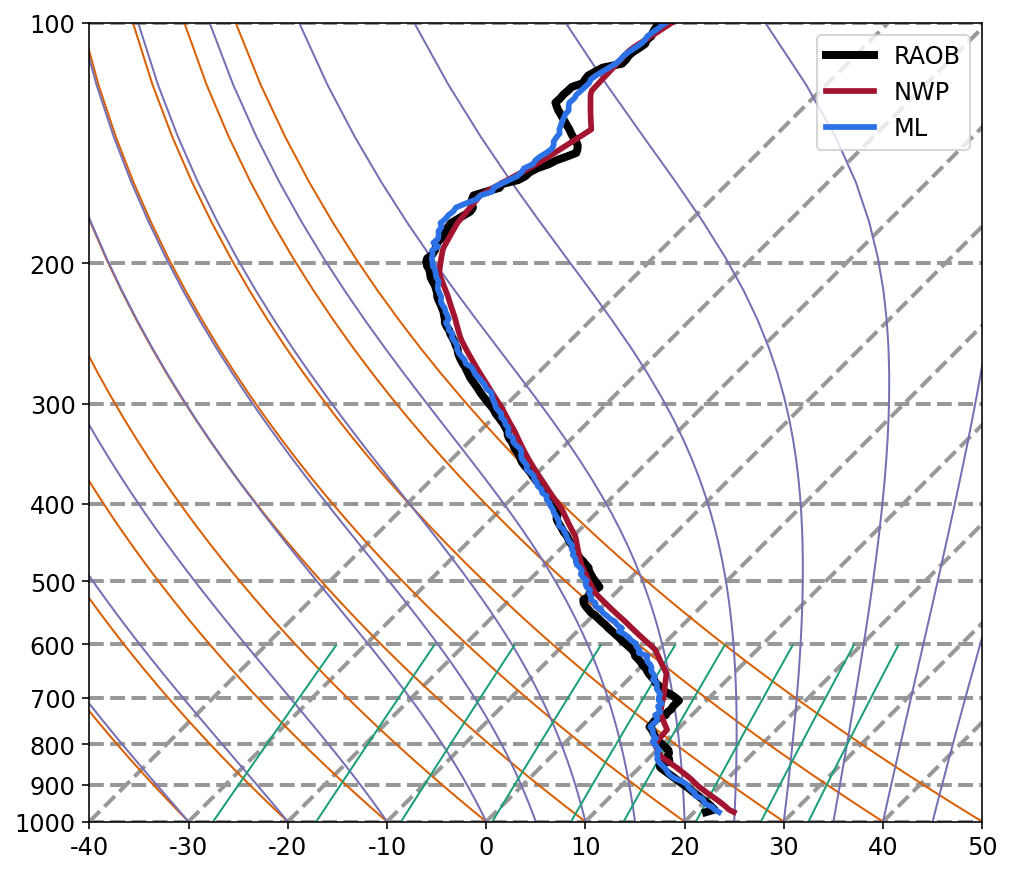

In [39]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':GOEStrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

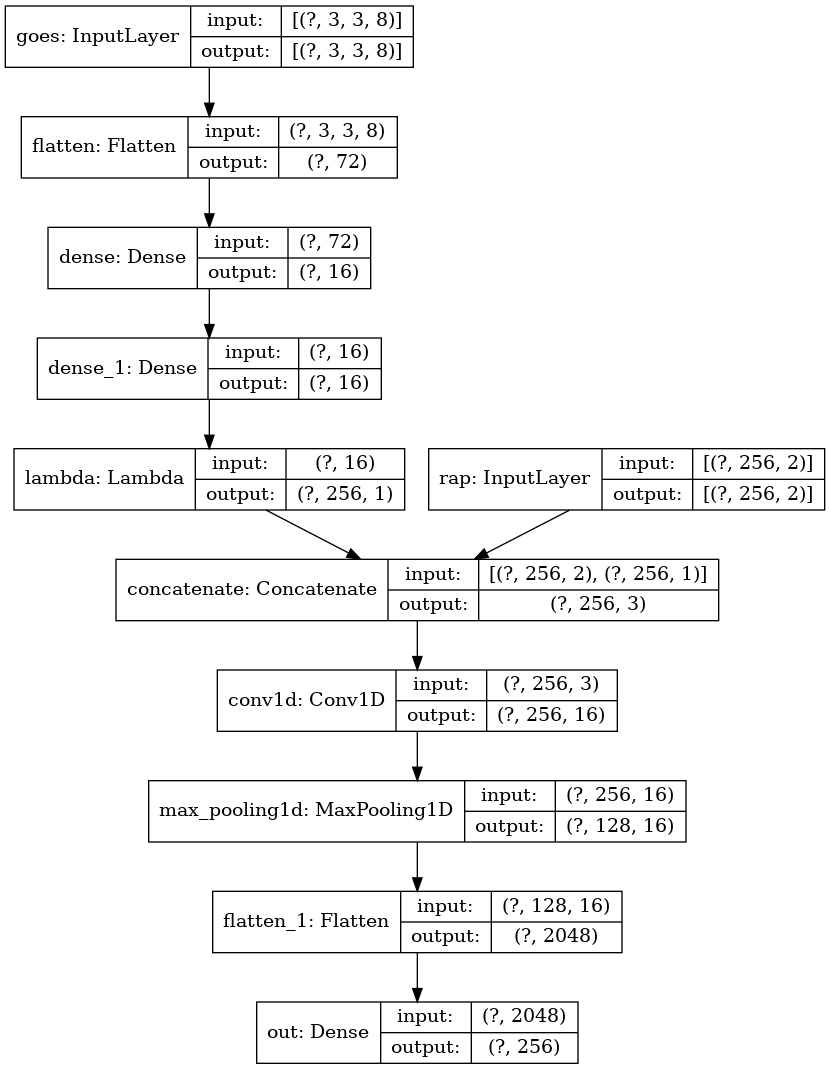

In [40]:
tf.keras.utils.plot_model(best_nnet.model, '/home/stock/research/media/multi_input_and_output_model.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

In [41]:
interm = tf.keras.Model(best_nnet.model.inputs,best_nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = best_nnet._standardizeGOES(goes)
    rap  = best_nnet._standardizeRAP(rap)
    return interm.predict({'imgoes': goes, 'rap': rap})

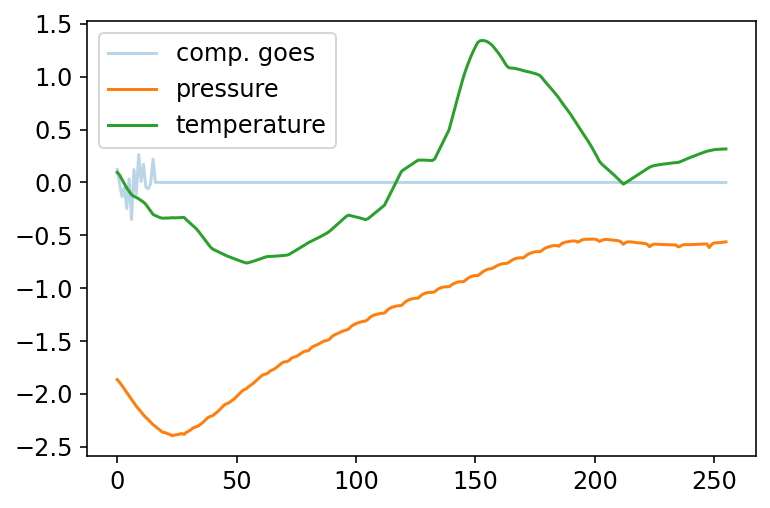

In [43]:
i = 0
Y = iterm_predict(GOEStrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

In [235]:
bands_indicies = np.arange(len(bands))
combinations = []
for length in [3]:
    combinations += list(itertools.combinations(bands_indicies, length+1))
len(combinations)

70

In [ ]:
all_trials = []
trials = 10

f = FloatProgress(min=0, max=len(combinations) * trials)
display(f)

for c in combinations:

    IMtrain = GOEStrain[:,:,:, c]
    IMtest = GOEStest[:,:,:, c]

    trial = []

    for t in range(trials):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [16, 16], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        f.value += 1
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

FloatProgress(value=0.0, max=700.0)

In [ ]:
labels = [bands[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(16, 4))

means = all_trials.mean(axis=1)

ax.errorbar(np.arange(len(combinations)), means, yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

top_index = np.argmin(means)
top = means[top_index]

ax.hlines(top, 0, len(means) - 1, linestyle='dashed', color='black')
ax.plot(top_index, top, 'k*', markersize=12, label=f'min: {top:.3f}')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('GOES Input'); ax.set_ylabel('RMSE');
ax.legend(loc=2);

# RAP + RTMA

In [44]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma)

input_dims = [PRESSURE, TEMPERATURE]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, TEMPERATURE]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((345, 256, 2),
 (345, 256),
 (345, 3, 3, 3),
 (86, 256, 2),
 (86, 256),
 (86, 3, 3, 3))

In [71]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [16, 32, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], goes_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

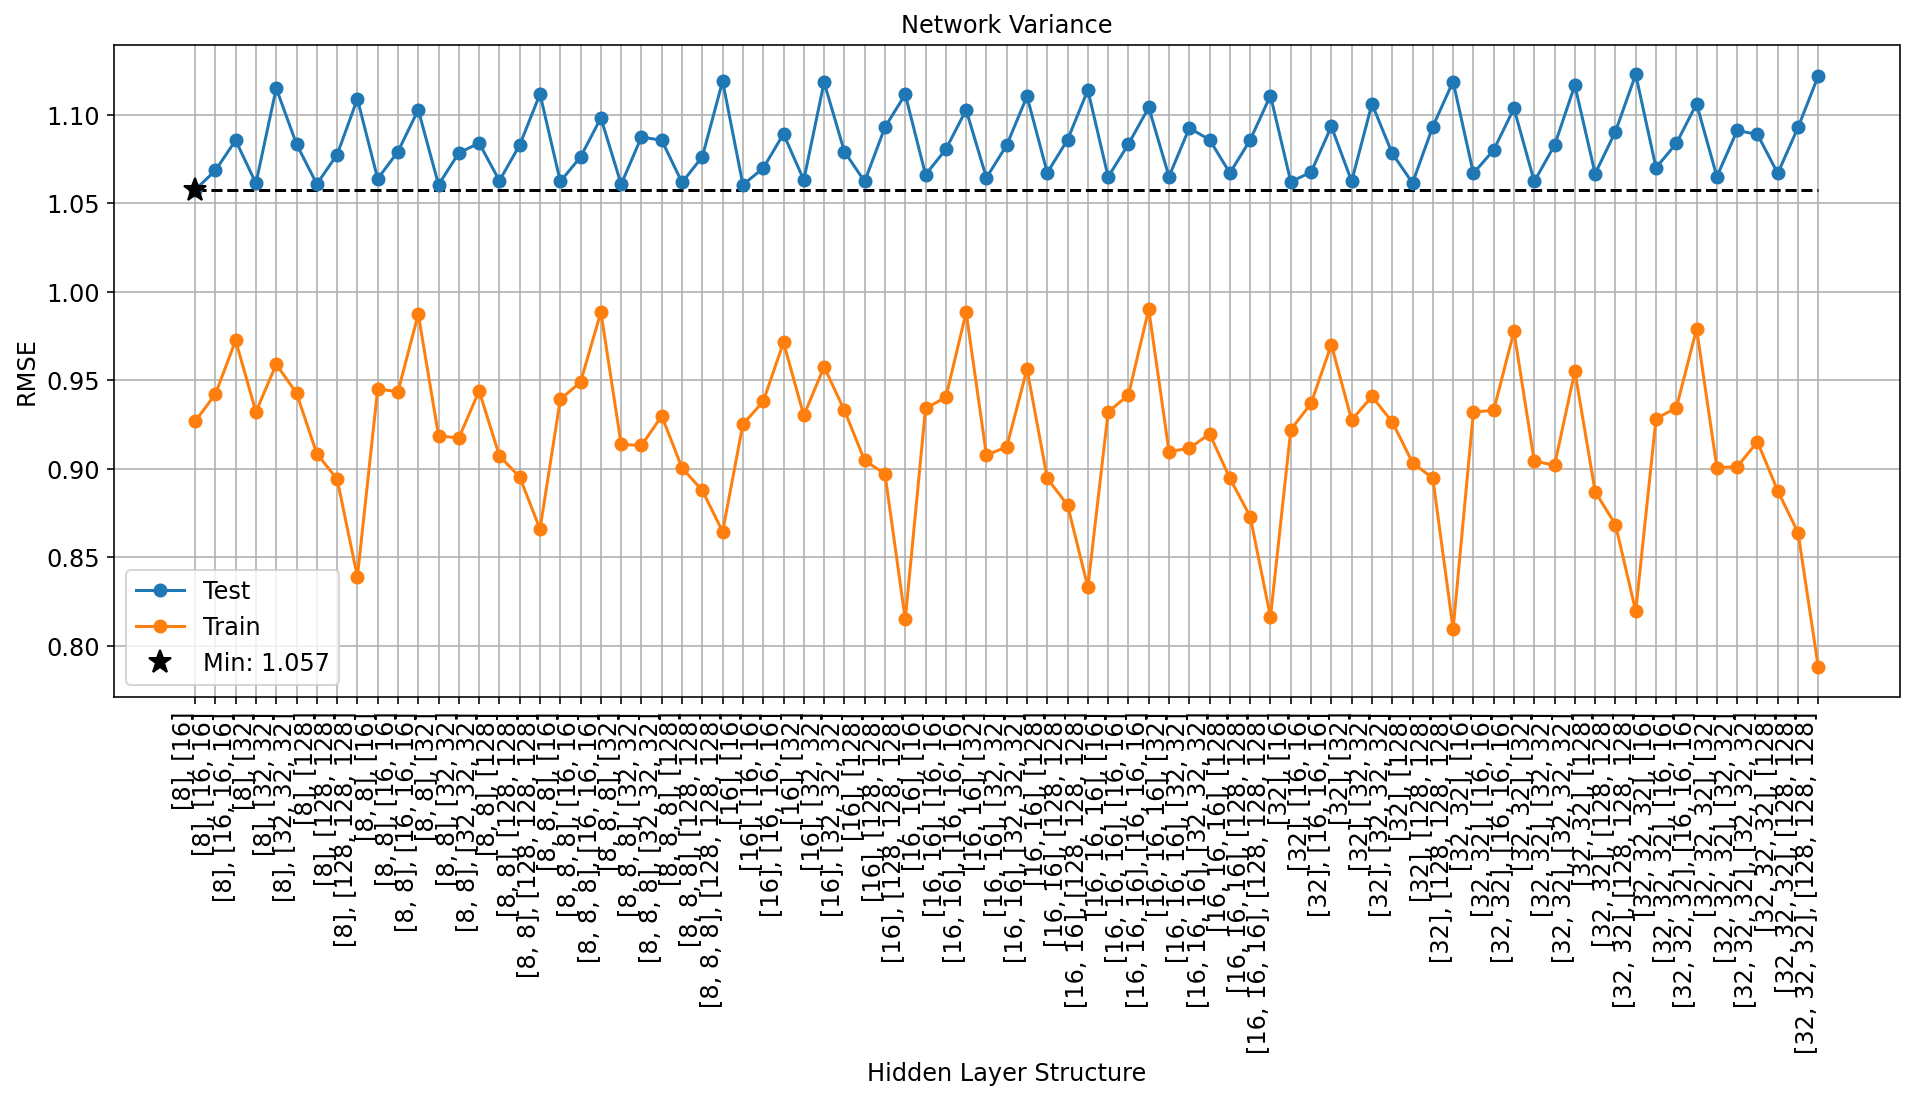

In [72]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

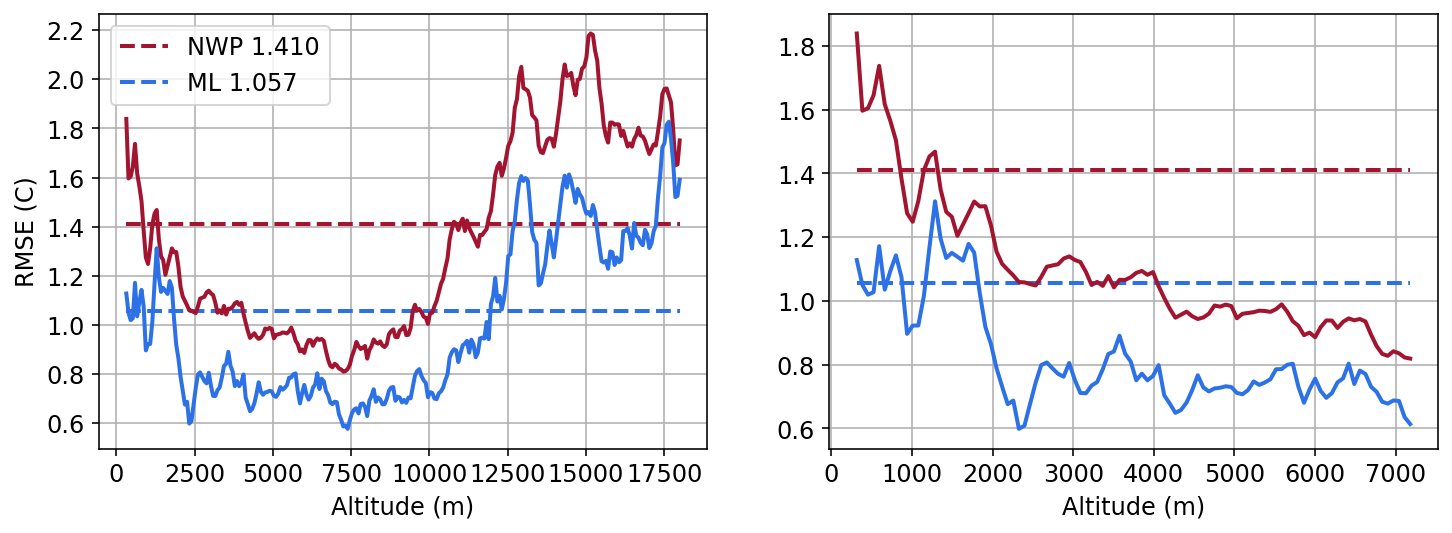

In [73]:
plot_altitude_rmse(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,TEMPERATURE])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

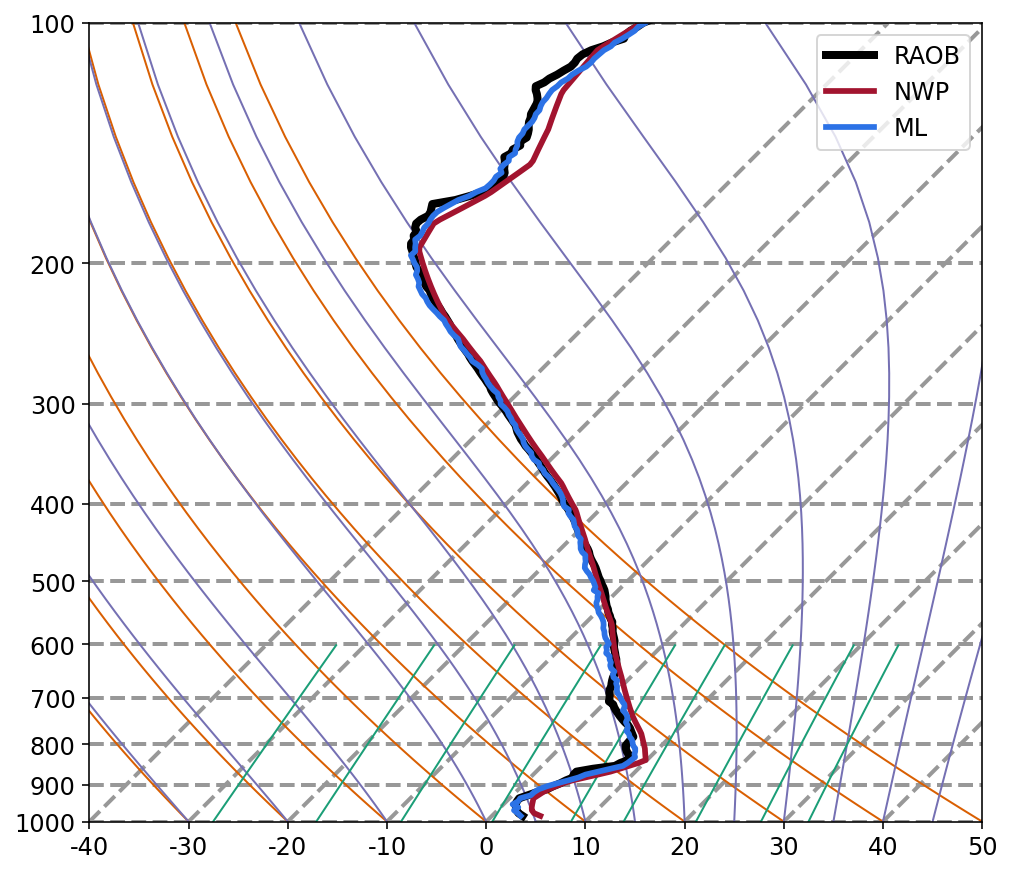

In [74]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [75]:
best_nnet.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
goes (InputLayer)               [(None, 3, 3, 3)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 27)           0           goes[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            224         flatten[0][0]                    
__________________________________________________________________________________________________
rap (InputLayer)                [(None, 256, 2)]     0                                            
_______________________________________________________________________________________

In [76]:
interm = tf.keras.Model(best_nnet.model.inputs,best_nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = best_nnet._standardizeGOES(goes)
    rap  = best_nnet._standardizeRAP(rap)
    return interm.predict({'im': goes, 'rap': rap})

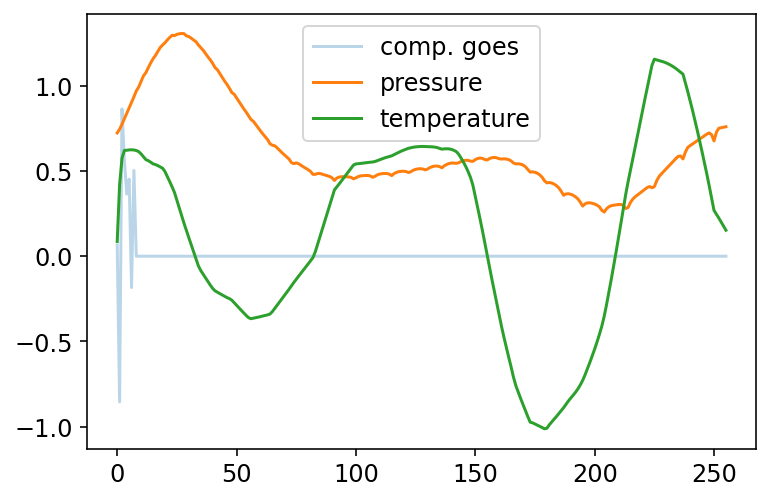

In [77]:
i = 2
Y = iterm_predict(RTMAtrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

In [100]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [174]:
all_trials = []

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(10):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [8], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

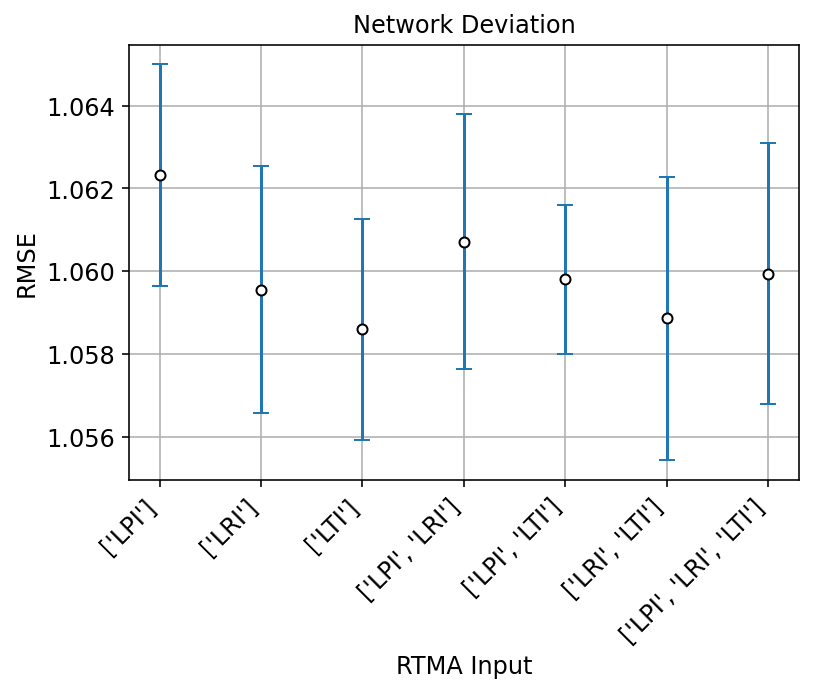

In [212]:
labels = [rtma_type[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

# RAP + GOES + RTMA